In [1]:
import pandas
from sklearn import metrics
from elasticsearch import Elasticsearch
import time
import gc
import random
import xgboost as xgb
import json
import shap
import numpy
from matplotlib import pyplot as plt

In [2]:
df = pandas.read_csv('data/dataset_400features.csv')
df

,borrower,snapshot,project,2u_defix,2v_04,2w_1,2a_03u_defix,2a_03v_04,2a_03w_1,2b_05,...,2s_t_9ff58f4ffb29fa2,2s_t_ffc97d72e13e010,2s_t_a06bc25b5805d5f,2s_t_6c3c78838c761c6,2s_a_04v_02,2s_a_02t_3b484b82567a09e,2a_03t_35a18000230da77,2s_a_03t_ae7ab96520de3a1,origin,label
0,0xe8215f5aee29a1db273c80c9d269e8fa44b39126,2021-02,Aave,77.0,39.0,80.0,16.0,11.0,18.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
1,0xf8219bd4d474a8ed9e4041d6cae01467f3ee1e56,2022-05,Aave,22.0,15.0,50.0,2.0,2.0,7.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
2,0xf9a6ed52c4988580954672aa91a1d5eb229e5c78,2021-10,Aave,16.0,42.0,78.0,3.0,5.0,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
3,0x8032244b3b41b487d8de22363bc436e869e6859f,2022-06,Aave,26.0,16.0,60.0,2.0,3.0,13.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
4,0x8032244b3b41b487d8de22363bc436e869e6859f,2022-03,Aave,20.0,4.0,28.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204730,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-07,Compound,385.0,155.0,331.0,86.0,38.0,59.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204731,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-08,Compound,398.0,158.0,343.0,87.0,38.0,60.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204732,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-09,Compound,409.0,161.0,353.0,91.0,39.0,63.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204733,0x5f75fb6104ac8ce72879347db1041adf2f7745d6,2021-07,Compound,28.0,14.0,45.0,8.0,3.0,11.0,3.0,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,True,0


In [3]:
not_features = [
    'borrower',
    'snapshot',
    'project',
    'origin',
    'label'
]

In [4]:
fs = [x for x in df.columns if x not in not_features]
len(fs)

400

In [5]:
bst = xgb.Booster()
bst.load_model('models/xgb400_aave_only')

In [6]:
df['score'] = bst.predict(xgb.DMatrix(df[fs]))

In [7]:
metrics.roc_auc_score(df['label'], df['score'])

0.6414864750564157

In [8]:
df_sample = df.sample(5000)

In [9]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer(df_sample[fs])

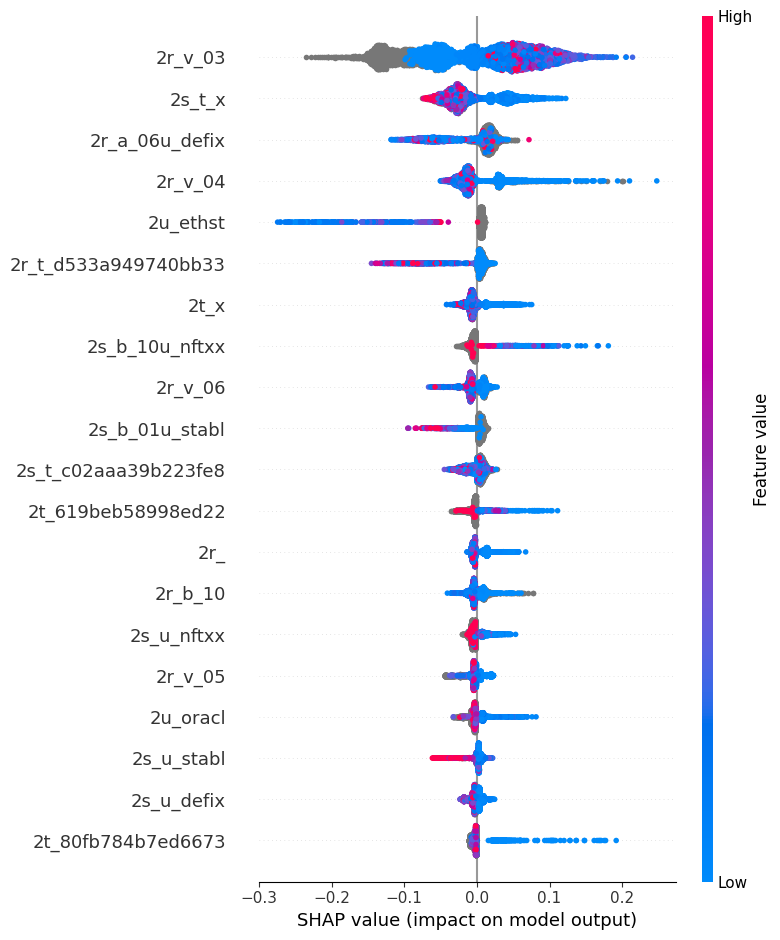

In [10]:
shap.summary_plot(shap_values, df_sample[fs])

In [11]:
importance = numpy.abs(shap_values.values).mean(0).tolist()
importance

[0.003983224742114544,
 0.0007170444587245584,
 0.0,
 0.00013973434397485107,
 0.0022407120559364557,
 0.000886986090335995,
 0.0023114224895834923,
 0.0,
 0.00034857227001339197,
 0.007793024647980928,
 0.0021103990729898214,
 0.02432820573449135,
 0.001092296908609569,
 0.0006724934792146087,
 0.00017138551629614085,
 7.298581476788968e-05,
 0.00035605428274720907,
 0.0003655977488961071,
 4.867306415690109e-05,
 0.0,
 0.006015966646373272,
 0.0013817223953083158,
 0.0,
 0.0006468171486631036,
 0.0016441303305327892,
 0.001764294458553195,
 0.0,
 0.00017299044702667743,
 9.568109817337245e-06,
 0.0010203272104263306,
 0.0,
 1.4335008017951623e-05,
 8.385480032302439e-05,
 0.0001707550836727023,
 1.4370222743309569e-05,
 0.000315101002342999,
 0.011460515670478344,
 0.00048610896919853985,
 0.0011092271888628602,
 0.0004957964993081987,
 0.034444037824869156,
 0.0,
 0.00010074712918139994,
 0.00020809739362448454,
 0.0019085075473412871,
 0.0007845989894121885,
 0.00018910368089564145

In [12]:
fs 

['2u_defix',
 '2v_04',
 '2w_1',
 '2a_03u_defix',
 '2a_03v_04',
 '2a_03w_1',
 '2b_05',
 '2b_05u_defix',
 '2b_05w_1',
 '2r_',
 '2r_u_defix',
 '2r_v_04',
 '2r_w_1',
 '2r_a_03',
 '2r_a_03u_defix',
 '2r_a_03v_04',
 '2r_a_03w_1',
 '2r_b_05',
 '2r_b_05u_defix',
 '2s_',
 '2s_u_defix',
 '2s_v_04',
 '2s_w_1',
 '2s_a_03u_defix',
 '2s_a_03v_04',
 '2s_a_03w_1',
 '2s_b_05u_defix',
 '2s_b_05v_04',
 '2s_b_05w_1',
 '2b_06',
 '2b_06u_defix',
 '2b_06v_04',
 '2b_06w_1',
 '2r_b_06',
 '2r_b_06u_defix',
 '2r_b_06v_04',
 '2t_x',
 '2a_05t_x',
 '2b_10',
 '2b_10t_x',
 '2s_t_x',
 '2s_a_05',
 '2s_b_10',
 '2s_b_10t_x',
 '2r_t_x',
 '2r_a_05',
 '2r_a_05t_x',
 '2r_b_10',
 '2r_b_10t_x',
 '2a_02',
 '2a_02v_04',
 '2a_02w_1',
 '2r_a_02',
 '2r_a_02w_1',
 '2u_dexxx',
 '2a_01',
 '2a_01u_defix',
 '2a_01w_1',
 '2b_02',
 '2b_02u_defix',
 '2b_02v_04',
 '2r_u_dexxx',
 '2r_a_01',
 '2r_a_01u_defix',
 '2r_a_01w_1',
 '2r_b_02',
 '2r_b_02v_04',
 '2v_05',
 '2a_02v_05',
 '2b_03',
 '2b_03u_defix',
 '2b_03v_05',
 '2b_03w_1',
 '2s_v_05',
 

In [13]:
descriptions = [
  "Sent or received any amount of tokens tagged as DEFI any time",
  "Sent or received any amount of tokens with M activity any time",
  "Sent or received any amount of mainstream tokens any time",
  "Sent or received an amount worth $100 - $1k of tokens tagged as DEFI any time",
  "Sent or received an amount worth $100 - $1k of tokens with M activity any time",
  "Sent or received an amount worth $100 - $1k of mainstream tokens any time",
  "Sent or received an amount in the 40-50th percentile of any token any time",
  "Sent or received an amount in the 40-50th percentile of tokens tagged as DEFI any time",
  "Sent or received an amount in the 40-50th percentile of mainstream tokens any time",
  "Received any amount of any token any time",
  "Received any amount of tokens tagged as DEFI any time",
  "Received any amount of tokens with M activity any time",
  "Received any amount of mainstream tokens any time",
  "Received an amount worth $100 - $1k of any token any time",
  "Received an amount worth $100 - $1k of tokens tagged as DEFI any time",
  "Received an amount worth $100 - $1k of tokens with M activity any time",
  "Received an amount worth $100 - $1k of mainstream tokens any time",
  "Received an amount in the 40-50th percentile of any token any time",
  "Received an amount in the 40-50th percentile of tokens tagged as DEFI any time",
  "Sent any amount of any token any time",
  "Sent any amount of tokens tagged as DEFI any time",
  "Sent any amount of tokens with M activity any time",
  "Sent any amount of mainstream tokens any time",
  "Sent an amount worth $100 - $1k of tokens tagged as DEFI any time",
  "Sent an amount worth $100 - $1k of tokens with M activity any time",
  "Sent an amount worth $100 - $1k of mainstream tokens any time",
  "Sent an amount in the 40-50th percentile of tokens tagged as DEFI any time",
  "Sent an amount in the 40-50th percentile of tokens with M activity any time",
  "Sent an amount in the 40-50th percentile of mainstream tokens any time",
  "Sent or received an amount in the 50-60th percentile of any token any time",
  "Sent or received an amount in the 50-60th percentile of tokens tagged as DEFI any time",
  "Sent or received an amount in the 50-60th percentile of tokens with M activity any time",
  "Sent or received an amount in the 50-60th percentile of mainstream tokens any time",
  "Received an amount in the 50-60th percentile of any token any time",
  "Received an amount in the 50-60th percentile of tokens tagged as DEFI any time",
  "Received an amount in the 50-60th percentile of tokens with M activity any time",
  "Sent or received any amount of Ether any time",
  "Sent or received an amount worth $10k - $100k of Ether any time",
  "Sent or received an amount in the +90th percentile of any token any time",
  "Sent or received an amount in the +90th percentile of Ether any time",
  "Sent any amount of Ether any time",
  "Sent an amount worth $10k - $100k of any token any time",
  "Sent an amount in the +90th percentile of any token any time",
  "Sent an amount in the +90th percentile of Ether any time",
  "Received any amount of Ether any time",
  "Received an amount worth $10k - $100k of any token any time",
  "Received an amount worth $10k - $100k of Ether any time",
  "Received an amount in the +90th percentile of any token any time",
  "Received an amount in the +90th percentile of Ether any time",
  "Sent or received an amount worth $10 - $100 of any token any time",
  "Sent or received an amount worth $10 - $100 of tokens with M activity any time",
  "Sent or received an amount worth $10 - $100 of mainstream tokens any time",
  "Received an amount worth $10 - $100 of any token any time",
  "Received an amount worth $10 - $100 of mainstream tokens any time",
  "Sent or received any amount of tokens tagged as DEX any time",
  "Sent or received an amount worth <$10 of any token any time",
  "Sent or received an amount worth <$10 of tokens tagged as DEFI any time",
  "Sent or received an amount worth <$10 of mainstream tokens any time",
  "Sent or received an amount in the 10-20th percentile of any token any time",
  "Sent or received an amount in the 10-20th percentile of tokens tagged as DEFI any time",
  "Sent or received an amount in the 10-20th percentile of tokens with M activity any time",
  "Received any amount of tokens tagged as DEX any time",
  "Received an amount worth <$10 of any token any time",
  "Received an amount worth <$10 of tokens tagged as DEFI any time",
  "Received an amount worth <$10 of mainstream tokens any time",
  "Received an amount in the 10-20th percentile of any token any time",
  "Received an amount in the 10-20th percentile of tokens with M activity any time",
  "Sent or received any amount of tokens with L activity any time",
  "Sent or received an amount worth $10 - $100 of tokens with L activity any time",
  "Sent or received an amount in the 20-30th percentile of any token any time",
  "Sent or received an amount in the 20-30th percentile of tokens tagged as DEFI any time",
  "Sent or received an amount in the 20-30th percentile of tokens with L activity any time",
  "Sent or received an amount in the 20-30th percentile of mainstream tokens any time",
  "Sent any amount of tokens with L activity any time",
  "Sent an amount worth $10 - $100 of any token any time",
  "Sent an amount worth $10 - $100 of tokens with L activity any time",
  "Sent an amount worth $10 - $100 of mainstream tokens any time",
  "Sent an amount in the 20-30th percentile of any token any time",
  "Sent an amount in the 20-30th percentile of tokens tagged as DEFI any time",
  "Sent an amount in the 20-30th percentile of mainstream tokens any time",
  "Received any amount of tokens with L activity any time",
  "Received an amount in the 20-30th percentile of mainstream tokens any time",
  "Sent or received any amount of WETH (WETH) any time",
  "Sent or received an amount worth $10k - $100k of mainstream tokens any time",
  "Sent or received an amount in the 60-70th percentile of any token any time",
  "Sent or received an amount in the 60-70th percentile of tokens with L activity any time",
  "Sent or received an amount in the 60-70th percentile of mainstream tokens any time",
  "Sent any amount of WETH (WETH) any time",
  "Sent an amount worth $10k - $100k of WETH (WETH) any time",
  "Sent an amount worth $10k - $100k of tokens with L activity any time",
  "Sent an amount worth $10k - $100k of mainstream tokens any time",
  "Sent an amount in the 60-70th percentile of any token any time",
  "Sent an amount in the 60-70th percentile of mainstream tokens any time",
  "Received any amount of WETH (WETH) any time",
  "Received an amount worth $10k - $100k of mainstream tokens any time",
  "Received an amount in the 60-70th percentile of any token any time",
  "Received an amount in the 60-70th percentile of mainstream tokens any time",
  "Sent or received any amount of tokens tagged as STABLE any time",
  "Sent or received any amount of exotic tokens any time",
  "Sent any amount of tokens tagged as STABLE any time",
  "Sent any amount of exotic tokens any time",
  "Received any amount of tokens tagged as STABLE any time",
  "Received any amount of exotic tokens any time",
  "Sent an amount worth $10 - $100 of tokens with M activity any time",
  "Sent an amount in the 50-60th percentile of any token any time",
  "Sent an amount in the 50-60th percentile of tokens tagged as DEFI any time",
  "Sent an amount in the 50-60th percentile of mainstream tokens any time",
  "Sent or received any amount of tokens with XL activity any time",
  "Sent or received an amount worth $1k - $10k of any token any time",
  "Sent or received an amount worth $1k - $10k of tokens tagged as DEFI any time",
  "Sent or received an amount worth $1k - $10k of mainstream tokens any time",
  "Sent or received an amount in the 80-90th percentile of any token any time",
  "Sent or received an amount in the 80-90th percentile of tokens with XL activity any time",
  "Sent or received an amount in the 80-90th percentile of mainstream tokens any time",
  "Sent any amount of tokens with XL activity any time",
  "Sent an amount worth $1k - $10k of any token any time",
  "Sent an amount worth $1k - $10k of tokens tagged as DEX any time",
  "Sent an amount worth $1k - $10k of tokens tagged as DEFI any time",
  "Sent an amount worth $1k - $10k of tokens with XL activity any time",
  "Sent an amount worth $1k - $10k of mainstream tokens any time",
  "Sent an amount in the 80-90th percentile of any token any time",
  "Sent an amount in the 80-90th percentile of tokens tagged as DEX any time",
  "Sent an amount in the 80-90th percentile of tokens tagged as DEFI any time",
  "Sent an amount in the 80-90th percentile of tokens with XL activity any time",
  "Sent an amount in the 80-90th percentile of mainstream tokens any time",
  "Received any amount of tokens with XL activity any time",
  "Received an amount worth $1k - $10k of tokens tagged as DEFI any time",
  "Received an amount in the 80-90th percentile of any token any time",
  "Received an amount in the 80-90th percentile of tokens tagged as DEX any time",
  "Received an amount in the 80-90th percentile of tokens with XL activity any time",
  "Received an amount in the 80-90th percentile of mainstream tokens any time",
  "Sent or received any amount of SUSD (SUSD) any time",
  "Sent or received an amount worth $100 - $1k of tokens tagged as STABLE any time",
  "Sent or received an amount in the 30-40th percentile of any token any time",
  "Sent or received an amount in the 30-40th percentile of tokens tagged as DEFI any time",
  "Sent or received an amount in the 30-40th percentile of tokens with M activity any time",
  "Sent or received an amount in the 30-40th percentile of mainstream tokens any time",
  "Sent an amount worth $100 - $1k of tokens tagged as STABLE any time",
  "Sent an amount in the 30-40th percentile of any token any time",
  "Sent an amount in the 30-40th percentile of tokens tagged as STABLE any time",
  "Sent an amount in the 30-40th percentile of mainstream tokens any time",
  "Received an amount worth $100 - $1k of tokens tagged as STABLE any time",
  "Received an amount in the 30-40th percentile of tokens tagged as DEFI any time",
  "Received an amount in the 30-40th percentile of mainstream tokens any time",
  "Sent or received any amount of DAI (DAI) any time",
  "Sent or received an amount worth $100 - $1k of tokens with XL activity any time",
  "Sent any amount of DAI (DAI) any time",
  "Sent an amount worth $100 - $1k of tokens with XL activity any time",
  "Received any amount of DAI (DAI) any time",
  "Received an amount worth $100 - $1k of tokens with XL activity any time",
  "Sent or received an amount worth $1k - $10k of Ether any time",
  "Sent or received an amount in the 70-80th percentile of any token any time",
  "Sent or received an amount in the 70-80th percentile of Ether any time",
  "Received an amount worth $1k - $10k of Ether any time",
  "Received an amount in the 70-80th percentile of any token any time",
  "Sent an amount worth <$10 of tokens tagged as DEFI any time",
  "Sent an amount worth <$10 of tokens with M activity any time",
  "Sent an amount worth <$10 of mainstream tokens any time",
  "Sent an amount in the 10-20th percentile of any token any time",
  "Sent or received any amount of USD COIN (USDC) any time",
  "Sent or received an amount worth $10 - $100 of tokens tagged as STABLE any time",
  "Sent or received an amount worth $10 - $100 of tokens with XL activity any time",
  "Received any amount of USD COIN (USDC) any time",
  "Received an amount worth $10 - $100 of tokens with XL activity any time",
  "Sent or received any amount of tokens with S activity any time",
  "Sent or received an amount worth $10 - $100 of tokens with S activity any time",
  "Sent any amount of tokens with S activity any time",
  "Sent or received an amount in the <10th percentile of any token any time",
  "Sent or received an amount in the <10th percentile of tokens with M activity any time",
  "Sent or received an amount in the <10th percentile of mainstream tokens any time",
  "Sent an amount in the <10th percentile of any token any time",
  "Sent an amount in the <10th percentile of tokens tagged as DEFI any time",
  "Sent an amount in the <10th percentile of mainstream tokens any time",
  "Sent or received an amount in the 60-70th percentile of tokens tagged as DEFI any time",
  "Sent an amount in the 60-70th percentile of tokens tagged as DEFI any time",
  "Received an amount worth $1k - $10k of tokens with L activity any time",
  "Sent or received an amount in the 50-60th percentile of tokens with L activity any time",
  "Received an amount in the 50-60th percentile of tokens with L activity any time",
  "Sent or received an amount worth $10k - $100k of tokens tagged as DEFI any time",
  "Sent or received an amount in the +90th percentile of tokens tagged as DEFI any time",
  "Sent or received an amount in the +90th percentile of tokens with L activity any time",
  "Sent or received an amount in the +90th percentile of mainstream tokens any time",
  "Sent an amount worth $10k - $100k of tokens tagged as DEFI any time",
  "Sent an amount in the +90th percentile of tokens tagged as DEFI any time",
  "Sent an amount in the +90th percentile of tokens with L activity any time",
  "Sent an amount in the +90th percentile of mainstream tokens any time",
  "Received an amount worth $10k - $100k of tokens tagged as DEFI any time",
  "Received an amount in the +90th percentile of tokens tagged as DEFI any time",
  "Received an amount in the +90th percentile of tokens with L activity any time",
  "Sent or received any amount of CUNI (CUNI) any time",
  "Sent or received an amount worth $1k - $10k of tokens with M activity any time",
  "Sent or received an amount in the 70-80th percentile of tokens tagged as DEFI any time",
  "Sent or received an amount in the 70-80th percentile of tokens with M activity any time",
  "Sent or received an amount in the 70-80th percentile of mainstream tokens any time",
  "Sent an amount worth $1k - $10k of tokens with M activity any time",
  "Sent an amount in the 70-80th percentile of any token any time",
  "Received an amount worth $1k - $10k of tokens with M activity any time",
  "Received an amount in the 70-80th percentile of tokens tagged as DEFI any time",
  "Received an amount in the 70-80th percentile of tokens with M activity any time",
  "Received an amount in the 70-80th percentile of mainstream tokens any time",
  "Sent or received an amount worth $1k - $10k of USD COIN (USDC) any time",
  "Sent or received an amount worth $1k - $10k of tokens tagged as STABLE any time",
  "Sent or received an amount in the 80-90th percentile of USD COIN (USDC) any time",
  "Sent or received an amount in the 80-90th percentile of tokens tagged as STABLE any time",
  "Sent an amount worth $1k - $10k of USD COIN (USDC) any time",
  "Sent an amount worth $1k - $10k of tokens tagged as STABLE any time",
  "Sent an amount in the 80-90th percentile of USD COIN (USDC) any time",
  "Sent an amount in the 80-90th percentile of tokens tagged as STABLE any time",
  "Received an amount worth $1k - $10k of tokens tagged as STABLE any time",
  "Sent or received an amount worth <$10 of tokens with L activity any time",
  "Received an amount in the <10th percentile of any token any time",
  "Received an amount in the <10th percentile of mainstream tokens any time",
  "Sent or received an amount in the 70-80th percentile of tokens with L activity any time",
  "Sent an amount in the 70-80th percentile of tokens tagged as DEX any time",
  "Sent an amount in the 70-80th percentile of tokens with L activity any time",
  "Sent or received an amount worth $1k - $10k of WETH (WETH) any time",
  "Sent or received an amount in the 40-50th percentile of tokens with L activity any time",
  "Received an amount in the 40-50th percentile of tokens with L activity any time",
  "Sent or received an amount worth $100 - $1k of tokens with S activity any time",
  "Sent an amount worth $100 - $1k of tokens tagged as DEX any time",
  "Sent an amount worth $100 - $1k of tokens with S activity any time",
  "Received any amount of tokens with S activity any time",
  "Received an amount worth $100 - $1k of tokens tagged as DEX any time",
  "Sent or received an amount worth $10k - $100k of tokens tagged as STABLE any time",
  "Sent or received an amount worth $10k - $100k of tokens with M activity any time",
  "Sent or received an amount in the 70-80th percentile of tokens tagged as STABLE any time",
  "Sent an amount worth $10k - $100k of tokens tagged as STABLE any time",
  "Sent an amount worth $10k - $100k of tokens with M activity any time",
  "Sent an amount in the 70-80th percentile of tokens tagged as STABLE any time",
  "Received an amount worth $10k - $100k of tokens tagged as STABLE any time",
  "Received an amount worth $10k - $100k of tokens with M activity any time",
  "Sent or received an amount in the 70-80th percentile of tokens with XL activity any time",
  "Sent an amount in the 70-80th percentile of tokens with XL activity any time",
  "Received an amount in the 80-90th percentile of Ether any time",
  "Sent or received an amount worth $10k - $100k of tokens with XL activity any time",
  "Sent or received an amount in the +90th percentile of USD COIN (USDC) any time",
  "Sent or received an amount in the +90th percentile of tokens tagged as STABLE any time",
  "Sent or received an amount in the +90th percentile of tokens with XL activity any time",
  "Sent an amount worth $10k - $100k of USD COIN (USDC) any time",
  "Sent an amount worth $10k - $100k of tokens with XL activity any time",
  "Sent an amount in the +90th percentile of tokens tagged as STABLE any time",
  "Sent an amount in the +90th percentile of tokens with XL activity any time",
  "Received an amount worth $10k - $100k of USD COIN (USDC) any time",
  "Received an amount in the +90th percentile of tokens tagged as STABLE any time",
  "Sent or received an amount in the 60-70th percentile of tokens with XL activity any time",
  "Received an amount in the 60-70th percentile of tokens tagged as STABLE any time",
  "Received an amount in the 60-70th percentile of tokens with XL activity any time",
  "Sent an amount worth $1k - $10k of Ether any time",
  "Sent or received an amount in the 80-90th percentile of tokens with L activity any time",
  "Sent an amount in the 80-90th percentile of tokens with L activity any time",
  "Received an amount in the 80-90th percentile of tokens with L activity any time",
  "Sent or received an amount in the 60-70th percentile of tokens with M activity any time",
  "Sent or received an amount in the 80-90th percentile of tokens with M activity any time",
  "Sent an amount in the 80-90th percentile of tokens with M activity any time",
  "Received an amount worth $10k - $100k of DAI (DAI) any time",
  "Sent or received an amount worth $100 - $1k of Ether any time",
  "Received an amount worth $100 - $1k of Ether any time",
  "Received an amount in the 40-50th percentile of Ether any time",
  "Sent or received an amount worth $100 - $1k of tokens with L activity any time",
  "Sent or received an amount in the 50-60th percentile of tokens tagged as DEX any time",
  "Sent an amount worth $100 - $1k of tokens with L activity any time",
  "Received an amount worth $100 - $1k of tokens with L activity any time",
  "Sent or received any amount of tokens with XS activity any time",
  "Sent or received an amount worth $100 - $1k of tokens with XS activity any time",
  "Sent any amount of tokens with XS activity any time",
  "Sent an amount worth $100 - $1k of tokens with XS activity any time",
  "Sent or received any amount of INSTADAPP (INST) any time",
  "Sent or received an amount in the +90th percentile of DAI (DAI) any time",
  "Sent or received any amount of tokens tagged as NFT any time",
  "Sent any amount of tokens tagged as NFT any time",
  "Sent or received any amount of TETHER USD (USDT) any time",
  "Sent or received any amount of tokens with XXL activity any time",
  "Sent any amount of tokens with XXL activity any time",
  "Received any amount of tokens with XXL activity any time",
  "Sent or received an amount in the +90th percentile of tokens with M activity any time",
  "Sent an amount in the +90th percentile of tokens with M activity any time",
  "Received an amount in the +90th percentile of tokens with M activity any time",
  "Sent or received any amount of CETH (CETH) any time",
  "Received any amount of CETH (CETH) any time",
  "Sent or received an amount worth $10 - $100 of Ether any time",
  "Sent an amount worth $10 - $100 of Ether any time",
  "Received an amount in the 60-70th percentile of Ether any time",
  "Sent or received an amount in the <10th percentile of USD COIN (USDC) any time",
  "Sent or received an amount in the <10th percentile of tokens tagged as STABLE any time",
  "Sent an amount worth $10 - $100 of tokens tagged as STABLE any time",
  "Sent an amount in the <10th percentile of tokens tagged as STABLE any time",
  "Received an amount in the <10th percentile of tokens tagged as STABLE any time",
  "Received an amount worth $10 - $100 of Ether any time",
  "Sent or received an amount in the 10-20th percentile of Ether any time",
  "Sent or received an amount in the 20-30th percentile of tokens with M activity any time",
  "Received an amount in the 20-30th percentile of tokens with M activity any time",
  "Sent or received an amount in the 30-40th percentile of Ether any time",
  "Sent or received an amount worth $100 - $1k of TETHER USD (USDT) any time",
  "Sent or received an amount in the 40-50th percentile of tokens with XL activity any time",
  "Sent or received an amount in the 50-60th percentile of tokens tagged as STABLE any time",
  "Sent or received an amount worth $100k - $1M of any token any time",
  "Sent an amount worth $100k - $1M of any token any time",
  "Received an amount worth $100k - $1M of any token any time",
  "Received an amount worth $100k - $1M of Ether any time",
  "Sent an amount in the 70-80th percentile of USD COIN (USDC) any time",
  "Sent or received an amount worth $100k - $1M of mainstream tokens any time",
  "Sent an amount worth $100k - $1M of mainstream tokens any time",
  "Received an amount worth $100k - $1M of mainstream tokens any time",
  "Sent an amount in the 50-60th percentile of tokens with XL activity any time",
  "Sent or received an amount worth $1k - $10k of TETHER USD (USDT) any time",
  "Sent an amount in the 20-30th percentile of tokens with M activity any time",
  "Sent or received any amount of tokens tagged as ORACLE any time",
  "Received an amount in the 60-70th percentile of tokens with M activity any time",
  "Received any amount of CURVE DAO TOKEN (CRV) any time",
  "Sent or received an amount worth $100k - $1M of tokens tagged as DEFI any time",
  "Sent or received an amount worth $100k - $1M of tokens with L activity any time",
  "Sent an amount worth $100k - $1M of tokens tagged as DEFI any time",
  "Received an amount worth $100k - $1M of tokens tagged as DEFI any time",
  "Sent or received any amount of WRAPPED BITCOIN (WBTC) any time",
  "Sent or received any amount of tokens tagged as BITCOIN any time",
  "Sent or received an amount worth $100 - $1k of tokens tagged as NFT any time",
  "Sent or received an amount in the 80-90th percentile of tokens tagged as NFT any time",
  "Sent any amount of WRAPPED BITCOIN (WBTC) any time",
  "Sent an amount worth $100 - $1k of Ether any time",
  "Sent an amount in the 60-70th percentile of Ether any time",
  "Sent or received an amount worth $1k - $10k of tokens with S activity any time",
  "Sent an amount worth $1k - $10k of tokens with S activity any time",
  "Received an amount worth $1k - $10k of tokens with S activity any time",
  "Sent an amount in the 40-50th percentile of Ether any time",
  "Sent or received any amount of AAVE INTEREST BEARING STETH (ASTETH) any time",
  "Sent or received any amount of AAVE VARIABLE DEBT BEARING USDC (VARIABLEDEBTUSDC) any time",
  "Received any amount of AAVE VARIABLE DEBT BEARING USDC (VARIABLEDEBTUSDC) any time",
  "Sent or received any amount of tokens tagged as ETHSTAKING any time",
  "Received any amount of LIDO STAKED ETHER (STETH) any time",
  "Received any amount of tokens tagged as ETHSTAKING any time",
  "Sent or received any amount of AAVE WETH (AWETH) any time",
  "Received any amount of AAVE WETH (AWETH) any time",
  "Sent any amount of AAVE VARIABLE DEBT BEARING USDC (VARIABLEDEBTUSDC) any time",
  "Sent or received any amount of NFTs any time",
  "Received any amount of NFTs any time",
  "Received an amount worth $100k - $1M of tokens with M activity any time",
  "Sent or received an amount worth $100k - $1M of tokens with XL activity any time",
  "Sent an amount worth <$10 of tokens tagged as STABLE any time",
  "Received an amount in the 40-50th percentile of tokens tagged as DEX any time",
  "Sent an amount in the 40-50th percentile of tokens with L activity any time",
  "Sent an amount in the 80-90th percentile of tokens tagged as NFT any time",
  "Sent any amount of CETH (CETH) any time",
  "Sent an amount worth $1k - $10k of tokens tagged as NFT any time",
  "Sent or received an amount worth $1M - $10M of any token any time",
  "Sent an amount worth $1M - $10M of any token any time",
  "Sent an amount in the 20-30th percentile of tokens with XL activity any time",
  "Sent or received any amount of A68.NET (A68.NET) any time",
  "Sent or received any amount of AAVE USDC (AUSDC) any time",
  "Received any amount of AAVE USDC (AUSDC) any time",
  "Received an amount worth $100 - $1k of tokens with XXL activity any time",
  "Sent an amount in the 50-60th percentile of Ether any time",
  "Sent or received any amount of CUSDT (CUSDT) any time",
  "Sent or received any amount of CDAI (CDAI) any time",
  "Received any amount of CDAI (CDAI) any time",
  "Received an amount worth $1M - $10M of tokens with XL activity any time",
  "Sent or received any amount of AAVE LINK (ALINK) any time",
  "Received any amount of AAVE LINK (ALINK) any time",
  "Sent or received an amount in the +90th percentile of WETH (WETH) any time",
  "Sent or received an amount in the +90th percentile of tokens tagged as NFT any time",
  "Sent an amount in the +90th percentile of tokens tagged as NFT any time",
  "Sent an amount in the 80-90th percentile of WRAPPED BITCOIN (WBTC) any time",
  "Sent or received any amount of BADGER DAO (BADGER) any time",
  "Received an amount in the +90th percentile of WETH (WETH) any time",
  "Received an amount in the +90th percentile of CETH (CETH) any time",
  "Sent an amount worth $100k - $1M of tokens tagged as DEX any time",
  "Sent any amount of CWBTC (CWBTC) any time",
  "Sent or received any amount of AAVE [OLD] (LEND) any time",
  "Sent or received any amount of MATIC NETWORK (MATIC) any time",
  "Received an amount in the 20-30th percentile of tokens tagged as POLKADOT any time",
  "Sent or received any amount of SAI (SAI) any time",
  "Received any amount of SAI (SAI) any time",
  "Sent any amount of MAKER (MKR) any time",
  "Sent any amount of AAVE [OLD] (LEND) any time",
  "Sent or received any amount of STAKED AAVE (STKAAVE) any time",
  "Received any amount of OPENDAO (SOS) any time",
  "Sent or received an amount in the <10th percentile of tokens tagged as DATA any time",
  "Sent an amount worth $100 - $1k of TETHER USD (USDT) any time",
  "Sent or received an amount worth $100 - $1k of CETH (CETH) any time",
  "Sent or received any amount of C0X (CZRX) any time",
  "Sent or received any amount of AAVE VARIABLE DEBT BEARING DAI (VARIABLEDEBTDAI) any time",
  "Sent or received any amount of AAVE WBTC (AWBTC) any time",
  "Received any amount of AAVE WBTC (AWBTC) any time",
  "Sent or received any amount of AAVE ETH (AETH) any time",
  "Received any amount of AAVE ETH (AETH) any time",
  "Sent any amount of AAVE ETH (AETH) any time",
  "Received an amount worth $1k - $10k of LIDO STAKED ETHER (STETH) any time",
  "Sent or received an amount worth $1k - $10k of CETH (CETH) any time",
  "Received an amount worth $1k - $10k of CETH (CETH) any time",
  "Received an amount worth $10k - $100k of AAVE ETH (AETH) any time",
  "Sent any amount of AAVE VARIABLE DEBT BEARING USDT (VARIABLEDEBTUSDT) any time",
  "Sent any amount of COMPOUND WRAPPED BTC (CWBTC) any time",
  "Sent any amount of AAVE WETH (AWETH) any time",
  "Sent any amount of AAVE WBTC (AWBTC) any time",
  "Sent any amount of AAVE AAVE (AAAVE) any time",
  "Sent any amount of ~0xa06bc25b5805d5f... any time",
  "Sent any amount of AAVE VARIABLE DEBT BEARING DAI (VARIABLEDEBTDAI) any time",
  "Sent an amount worth $1k - $10k of tokens with XS activity any time",
  "Sent an amount worth $10 - $100 of OPENDAO (SOS) any time",
  "Sent or received an amount worth $100 - $1k of CUNI (CUNI) any time",
  "Sent an amount worth $100 - $1k of LIDO STAKED ETHER (STETH) any time"
]

In [14]:
feature_table = pandas.DataFrame({'feature': fs, 'description': descriptions, 'importance': importance})
feature_table

,feature,description,importance
0,2u_defix,Sent or received any amount of tokens tagged a...,0.003983
1,2v_04,Sent or received any amount of tokens with M a...,0.000717
2,2w_1,Sent or received any amount of mainstream toke...,0.000000
3,2a_03u_defix,Sent or received an amount worth $100 - $1k of...,0.000140
4,2a_03v_04,Sent or received an amount worth $100 - $1k of...,0.002241
...,...,...,...
395,2s_t_6c3c78838c761c6,Sent any amount of AAVE VARIABLE DEBT BEARING ...,0.000000
396,2s_a_04v_02,Sent an amount worth $1k - $10k of tokens with...,0.000000
397,2s_a_02t_3b484b82567a09e,Sent an amount worth $10 - $100 of OPENDAO (SO...,0.000000
398,2a_03t_35a18000230da77,Sent or received an amount worth $100 - $1k of...,0.000000


In [15]:
feature_table.sort_values('importance', ascending=False, inplace=True)
pandas.set_option('display.max_colwidth', None)
feature_table.reset_index(inplace=True)
feature_table[:20]

,index,feature,description,importance
0,221,2r_v_03,Received any amount of tokens with S activity any time,0.071728
1,40,2s_t_x,Sent any amount of Ether any time,0.034444
2,312,2r_a_06u_defix,Received an amount worth $100k - $1M of tokens tagged as DEFI any time,0.028058
3,11,2r_v_04,Received any amount of tokens with M activity any time,0.024328
4,327,2u_ethst,Sent or received any amount of tokens tagged as ETHSTAKING any time,0.014674
5,308,2r_t_d533a949740bb33,Received any amount of CURVE DAO TOKEN (CRV) any time,0.013542
6,36,2t_x,Sent or received any amount of Ether any time,0.011461
7,359,2s_b_10u_nftxx,Sent an amount in the +90th percentile of tokens tagged as NFT any time,0.010881
8,125,2r_v_06,Received any amount of tokens with XL activity any time,0.010278
9,285,2s_b_01u_stabl,Sent an amount in the <10th percentile of tokens tagged as STABLE any time,0.009686


In [19]:
df_test1 = df[(df['project']=='Aave') & (df['snapshot']=='2022-06')]
len(df_test1)

4682

In [20]:
df_test2 = df[(df['project']=='Aave') & (df['snapshot']=='2022-08')]
len(df_test2)

5067

In [33]:
shap_values1 = explainer(df_test1[fs])
shap_values2 = explainer(df_test2[fs])

In [36]:
importance_compare = pandas.DataFrame({
    'feature': fs,
    'description': descriptions,
    'effect1': list(shap_values1.mean(0).values),
    'effect2': list(shap_values2.mean(0).values),
})
importance_compare

,feature,description,effect1,effect2
0,2u_defix,Sent or received any amount of tokens tagged as DEFI any time,-0.000859,-0.003327
1,2v_04,Sent or received any amount of tokens with M activity any time,0.000345,0.001056
2,2w_1,Sent or received any amount of mainstream tokens any time,0.000000,0.000000
3,2a_03u_defix,Sent or received an amount worth $100 - $1k of tokens tagged as DEFI any time,-0.000051,-0.000087
4,2a_03v_04,Sent or received an amount worth $100 - $1k of tokens with M activity any time,-0.000274,-0.000860
...,...,...,...,...
395,2s_t_6c3c78838c761c6,Sent any amount of AAVE VARIABLE DEBT BEARING DAI (VARIABLEDEBTDAI) any time,0.000000,0.000000
396,2s_a_04v_02,Sent an amount worth $1k - $10k of tokens with XS activity any time,0.000000,0.000000
397,2s_a_02t_3b484b82567a09e,Sent an amount worth $10 - $100 of OPENDAO (SOS) any time,0.000000,0.000000
398,2a_03t_35a18000230da77,Sent or received an amount worth $100 - $1k of CUNI (CUNI) any time,0.000000,0.000000


In [37]:
importance_compare['delta'] = importance_compare['effect2'] - importance_compare['effect1']
importance_compare['delta_abs'] = numpy.abs(importance_compare['delta'])
importance_compare.sort_values('delta_abs', ascending=False, inplace=True)
importance_compare.reset_index(inplace=True)
importance_compare[:20]

,index,feature,description,effect1,effect2,delta,delta_abs
0,221,2r_v_03,Received any amount of tokens with S activity any time,-0.004303,-0.041503,-0.037200,0.037200
1,327,2u_ethst,Sent or received any amount of tokens tagged as ETHSTAKING any time,-0.030446,-0.021943,0.008503,0.008503
2,11,2r_v_04,Received any amount of tokens with M activity any time,0.002372,0.009569,0.007197,0.007197
3,40,2s_t_x,Sent any amount of Ether any time,-0.010858,-0.006338,0.004520,0.004520
4,312,2r_a_06u_defix,Received an amount worth $100k - $1M of tokens tagged as DEFI any time,-0.001304,0.003156,0.004460,0.004460
5,308,2r_t_d533a949740bb33,Received any amount of CURVE DAO TOKEN (CRV) any time,-0.005003,-0.001777,0.003226,0.003226
6,125,2r_v_06,Received any amount of tokens with XL activity any time,-0.002884,-0.000153,0.002731,0.002731
7,0,2u_defix,Sent or received any amount of tokens tagged as DEFI any time,-0.000859,-0.003327,-0.002468,0.002468
8,80,2r_v_05,Received any amount of tokens with L activity any time,-0.002575,-0.004839,-0.002264,0.002264
9,9,2r_,Received any amount of any token any time,0.002174,0.004237,0.002063,0.002063
